<a href="https://colab.research.google.com/github/AlpacaAlice/DADS7203_5_Music_Generation/blob/main/Music_Generated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Process MIDI file

In [1]:
!pip install pretty_midi
!pip install keras_self_attention
!pip install music21
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=59c024fa52533c2a287e74709b650c427ec42d935818ce7d54ce7ad18049dce2
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=cc9ed8deab8c7a9e89d1aeaf863bea6e341474e3f6856f26dd0a1ed9f8066717
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fb

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files

# Upload kaggle.json
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d soumikrakshit/classical-music-midi
! mkdir drive/MyDrive/NLP
! unzip "classical-music-midi.zip" -d "/content/drive/MyDrive/NLP"

Saving kaggle.json to kaggle.json
  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 147MB/s]
Archive:  classical-music-midi.zip
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_esp1.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_esp2.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_esp3.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_esp4.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_esp5.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_esp6.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_se1.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_se2.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_se3.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_se4.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_se5.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_se6.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz/alb_se7.mid  
  inflating: /content/drive/MyDrive/NLP/albeniz

In [5]:
! mkdir encoded_data
! mkdir output

In [6]:
import pretty_midi
from music21 import *
import pickle
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import time
import os
import glob
from itertools import groupby
import math

from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D, Activation, GlobalMaxPooling2D
from keras_self_attention import SeqSelfAttention
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Layer
from tensorflow.python.client import device_lib
import keras

1. Extract MIDI

In [7]:
def extract_midi_info(path):
    mid = converter.parse(path)
    inp = instrument.partitionByInstrument(mid)
    piano_part = inp.parts[0].recurse()
    bpm = 100
    for i in piano_part:
        if isinstance(i, tempo.MetronomeMark):
            bpm = i.getQuarterBPM()
            break
    try:
        key = piano_part.keySignature
        key_in_major = key.asKey(mode='major')
        offset_by = key_in_major.tonic.pitchClass
    except:
        print(f"Error while finding key signature for song {temp}")
        offset_by = 0
    
    return offset_by, bpm

In [8]:
def preprocess_midi(path, offset_by, bpm):
    mid = pretty_midi.PrettyMIDI(midi_file=path)
    filtered_inst_ls = [inst for inst in mid.instruments if ((len(inst.notes) > 0) and
                                                    (inst.is_drum == False) and
                                                    (inst.program < 8)
                                                   )]
    piano = filtered_inst_ls[np.argmax([len(inst.notes) for inst in filtered_inst_ls])]
            
    start_time = piano.notes[0].start
    end_time = piano.get_end_time()
    
    quater_note_len = 60/bpm
#   Set 4 for 16th note, 8 for 32nd note
    nth_note = 8
    fs = 1/(quater_note_len/nth_note)
    
    piano_roll = piano.get_piano_roll(fs = fs, times = np.arange(start_time, end_time,1./fs))
#   Normalise key signature
    piano_roll = np.roll(piano_roll, -offset_by)
#   Set all velocity to 1
    out = np.where(piano_roll > 0, 1,0)
    
    return out.T

In [9]:
def process_piano_roll(piano_roll, max_consecutive = 64):
#   This function is to remove consecutive notes that last for more than roughtly 2 secs
    prev = np.random.rand(128)
    count = 0
    remove_idxs = []
    remove_slice = []
    for idx, piano_slice in enumerate(piano_roll):
        if(np.array_equal(prev, piano_slice)):
            count+=1
            if (count > max_consecutive):
                remove_idxs.append(idx)
                if (str(piano_slice) not in remove_slice):
                    remove_slice.append(str(piano_slice))
        else:
            count = 0
        prev = piano_slice
    out_piano_roll = np.delete(piano_roll, remove_idxs, axis=0)
    return out_piano_roll

2. Save MIDI output

In [10]:
failed_list = []
data_path = "/content/drive/MyDrive/NLP/"
encoded_data_path = "encoded_data/"
# keep track of list of midi we failed to parse and preprocess
for temp in glob.glob(data_path + "*/*.mid"):
    try:
        print(temp)
        offset_by, bpm = extract_midi_info(temp)
        piano_roll = preprocess_midi(temp, offset_by, bpm)
        piano_roll = process_piano_roll(piano_roll)
        name  = temp.split("/")[-1]
        auther = temp.split("/")[-2]
        out_name = encoded_data_path + f'encoded_{auther}_{name}.npy'
        np.save(out_name, piano_roll)
        print(f"saved {out_name}")
        
    except:
        print(f"Faield to preprocess {temp}")
        failed_list.append(temp)
        continue

/content/drive/MyDrive/NLP/albeniz/alb_esp1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
<ipython-input-7-3c13abe64566>:11: StreamIteratorInefficientWarning: keySignature is not defined on StreamIterators. Call .stream() first for efficiency
  key = piano_part.keySignature


saved encoded_data/encoded_albeniz_alb_esp1.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_esp2.mid
saved encoded_data/encoded_albeniz_alb_esp2.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_esp3.mid
saved encoded_data/encoded_albeniz_alb_esp3.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_esp4.mid
saved encoded_data/encoded_albeniz_alb_esp4.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_esp5.mid
saved encoded_data/encoded_albeniz_alb_esp5.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_esp6.mid
saved encoded_data/encoded_albeniz_alb_esp6.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_se1.mid
saved encoded_data/encoded_albeniz_alb_se1.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_se2.mid
saved encoded_data/encoded_albeniz_alb_se2.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_se3.mid
saved encoded_data/encoded_albeniz_alb_se3.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_se4.mid
saved encoded_data/encoded_albeniz_alb_se4.mid.npy
/content/drive/MyDrive/NLP/albeniz/alb_se5.mid
saved enc

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Copyright 2004 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_bach_bach_846.mid.npy
/content/drive/MyDrive/NLP/bach/bach_847.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=7, channel=None, data=b'Copyright 2004 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_bach_bach_847.mid.npy
/content/drive/MyDrive/NLP/bach/bach_850.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Pr\xe4ludium und Fuge in D-Dur, BWV 850'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Copyright 1997 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_bach_bach_850.mid.npy
/content/drive/MyDrive/NLP/balakir/islamei.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2000 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_balakir_islamei.mid.npy
/content/drive/MyDrive/NLP/beeth/appass_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_appass_1.mid.npy
/content/drive/MyDrive/NLP/beeth/appass_2.mid
saved encoded_data/encoded_beeth_appass_2.mid.npy
/content/drive/MyDrive/NLP/beeth/appass_3.mid
saved encoded_data/encoded_beeth_appass_3.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_hammerklavier_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2008 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_beethoven_hammerklavier_1.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_hammerklavier_2.mid
saved encoded_data/encoded_beeth_beethoven_hammerklavier_2.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_hammerklavier_3.mid
saved encoded_data/encoded_beeth_beethoven_hammerklavier_3.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_hammerklavier_4.mid
saved encoded_data/encoded_beeth_beethoven_hammerklavier_4.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_les_adieux_1.mid
saved encoded_data/encoded_beeth_beethoven_les_adieux_1.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_les_adieux_2.mid
saved encoded_data/encoded_beeth_beethoven_les_adieux_2.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_les_adieux_3.mid
saved encoded_data/encoded_beeth_beethoven_les_adieux_3.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_opus10_1.mid
saved encoded_data/encoded_beeth_beethoven_opus10_1.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_opus10_2.mid

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2009 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_beethoven_opus22_1.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_opus22_2.mid
saved encoded_data/encoded_beeth_beethoven_opus22_2.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_opus22_3.mid
saved encoded_data/encoded_beeth_beethoven_opus22_3.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_opus22_4.mid
saved encoded_data/encoded_beeth_beethoven_opus22_4.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_opus90_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_beethoven_opus90_1.mid.npy
/content/drive/MyDrive/NLP/beeth/beethoven_opus90_2.mid
saved encoded_data/encoded_beeth_beethoven_opus90_2.mid.npy
/content/drive/MyDrive/NLP/beeth/elise.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'F\xfcr Elise'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'Beethoven F\xfcr Elise'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_elise.mid.npy
/content/drive/MyDrive/NLP/beeth/mond_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Mondscheinsonate; der Gr\xe4fin Giulietta Guiccardi gewidmet'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_mond_1.mid.npy
/content/drive/MyDrive/NLP/beeth/mond_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_mond_2.mid.npy
/content/drive/MyDrive/NLP/beeth/mond_3.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_mond_3.mid.npy
/content/drive/MyDrive/NLP/beeth/pathetique_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 1. Movement'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_pathetique_1.mid.npy
/content/drive/MyDrive/NLP/beeth/pathetique_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 2. Movement'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=7, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_pathetique_2.mid.npy
/content/drive/MyDrive/NLP/beeth/pathetique_3.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 3. Movement'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_pathetique_3.mid.npy
/content/drive/MyDrive/NLP/beeth/waldstein_1.mid
saved encoded_data/encoded_beeth_waldstein_1.mid.npy
/content/drive/MyDrive/NLP/beeth/waldstein_2.mid
saved encoded_data/encoded_beeth_waldstein_2.mid.npy
/content/drive/MyDrive/NLP/beeth/waldstein_3.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_beeth_waldstein_3.mid.npy
/content/drive/MyDrive/NLP/borodin/bor_ps1.mid
saved encoded_data/encoded_borodin_bor_ps1.mid.npy
/content/drive/MyDrive/NLP/borodin/bor_ps2.mid
saved encoded_data/encoded_borodin_bor_ps2.mid.npy
/content/drive/MyDrive/NLP/borodin/bor_ps3.mid
saved encoded_data/encoded_borodin_bor_ps3.mid.npy
/content/drive/MyDrive/NLP/borodin/bor_ps4.mid
saved encoded_data/encoded_borodin_bor_ps4.mid.npy
/content/drive/MyDrive/NLP/borodin/bor_ps5.mid
saved encoded_data/encoded_borodin_bor_ps5.mid.npy
/content/drive/MyDrive/NLP/borodin/bor_ps6.mid
saved encoded_data/encoded_borodin_bor_ps6.mid.npy
/content/drive/MyDrive/NLP/borodin/bor_ps7.mid
saved encoded_data/encoded_borodin_bor_ps7.mid.npy
/content/drive/MyDrive/NLP/brahms/br_im2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_brahms_br_im2.mid.npy
/content/drive/MyDrive/NLP/brahms/br_im5.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_brahms_br_im5.mid.npy
/content/drive/MyDrive/NLP/brahms/br_rhap.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Produced 1997 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_brahms_br_rhap.mid.npy
/content/drive/MyDrive/NLP/brahms/brahms_opus117_1.mid
saved encoded_data/encoded_brahms_brahms_opus117_1.mid.npy
/content/drive/MyDrive/NLP/brahms/brahms_opus117_2.mid
saved encoded_data/encoded_brahms_brahms_opus117_2.mid.npy
/content/drive/MyDrive/NLP/brahms/brahms_opus1_1.mid
saved encoded_data/encoded_brahms_brahms_opus1_1.mid.npy
/content/drive/MyDrive/NLP/brahms/brahms_opus1_2.mid
saved encoded_data/encoded_brahms_brahms_opus1_2.mid.npy
/content/drive/MyDrive/NLP/brahms/brahms_opus1_3.mid
Faield to preprocess /content/drive/MyDrive/NLP/brahms/brahms_opus1_3.mid
/content/drive/MyDrive/NLP/brahms/brahms_opus1_4.mid
saved encoded_data/encoded_brahms_brahms_opus1_4.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_agitato.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2012 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_burgm_burg_agitato.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_erwachen.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_burgm_burg_erwachen.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_geschwindigkeit.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2012 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_burgm_burg_geschwindigkeit.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_gewitter.mid
saved encoded_data/encoded_burgm_burg_gewitter.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_perlen.mid
saved encoded_data/encoded_burgm_burg_perlen.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_quelle.mid
saved encoded_data/encoded_burgm_burg_quelle.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_spinnerlied.mid
saved encoded_data/encoded_burgm_burg_spinnerlied.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_sylphen.mid
saved encoded_data/encoded_burgm_burg_sylphen.mid.npy
/content/drive/MyDrive/NLP/burgm/burg_trennung.mid
saved encoded_data/encoded_burgm_burg_trennung.mid.npy
/content/drive/MyDrive/NLP/chopin/chp_op18.mid
saved encoded_data/encoded_chopin_chp_op18.mid.npy
/content/drive/MyDrive/NLP/chopin/chp_op31.mid
saved encoded_data/encoded_chopin_chp_op31.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn-p1.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p10.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn-p10.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p11.mid
saved encoded_data/encoded_chopin_chpn-p11.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p12.mid
saved encoded_data/encoded_chopin_chpn-p12.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p13.mid
saved encoded_data/encoded_chopin_chpn-p13.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p14.mid
saved encoded_data/encoded_chopin_chpn-p14.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p15.mid
saved encoded_data/encoded_chopin_chpn-p15.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p16.mid
saved encoded_data/encoded_chopin_chpn-p16.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p17.mid
saved encoded_data/encoded_chopin_chpn-p17.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p18.mid
saved encoded_data/encoded_chopin_chpn-p18.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p19.mid
saved encoded_data/encoded_chopin_chpn-p19.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p2.mid
saved encoded_data/en

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn-p8.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn-p9.mid
saved encoded_data/encoded_chopin_chpn-p9.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op10_e01.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Et\xfcde Opus 10 No. 5'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1999 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op10_e01.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op10_e05.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Schwarze-Tasten-Et\xfcde'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op10_e05.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op10_e12.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Et\xfcde Nr. 12'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op10_e12.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op23.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op23.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op25_e1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op25_e1.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op25_e11.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Et\xfcde Opus 25, No. 11'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Sturmet\xfcde'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op25_e11.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op25_e12.mid
saved encoded_data/encoded_chopin_chpn_op25_e12.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op25_e2.mid
saved encoded_data/encoded_chopin_chpn_op25_e2.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op25_e3.mid
saved encoded_data/encoded_chopin_chpn_op25_e3.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op25_e4.mid
saved encoded_data/encoded_chopin_chpn_op25_e4.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op27_1.mid
saved encoded_data/encoded_chopin_chpn_op27_1.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op27_2.mid
saved encoded_data/encoded_chopin_chpn_op27_2.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op33_2.mid
Faield to preprocess /content/drive/MyDrive/NLP/chopin/chpn_op33_2.mid
/content/drive/MyDrive/NLP/chopin/chpn_op33_4.mid
saved encoded_data/encoded_chopin_chpn_op33_4.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op35_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2002 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op35_1.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op35_2.mid
Faield to preprocess /content/drive/MyDrive/NLP/chopin/chpn_op35_2.mid
/content/drive/MyDrive/NLP/chopin/chpn_op35_3.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_chopin_chpn_op35_3.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op35_4.mid
saved encoded_data/encoded_chopin_chpn_op35_4.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op53.mid
saved encoded_data/encoded_chopin_chpn_op53.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op66.mid
saved encoded_data/encoded_chopin_chpn_op66.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op7_1.mid
saved encoded_data/encoded_chopin_chpn_op7_1.mid.npy
/content/drive/MyDrive/NLP/chopin/chpn_op7_2.mid
saved encoded_data/encoded_chopin_chpn_op7_2.mid.npy
/content/drive/MyDrive/NLP/debussy/deb_menu.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1998 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_debussy_deb_menu.mid.npy
/content/drive/MyDrive/NLP/debussy/deb_prel.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_debussy_deb_prel.mid.npy
/content/drive/MyDrive/NLP/debussy/debussy_cc_1.mid
saved encoded_data/encoded_debussy_debussy_cc_1.mid.npy
/content/drive/MyDrive/NLP/debussy/debussy_cc_2.mid
saved encoded_data/encoded_debussy_debussy_cc_2.mid.npy
/content/drive/MyDrive/NLP/debussy/debussy_cc_3.mid
saved encoded_data/encoded_debussy_debussy_cc_3.mid.npy
/content/drive/MyDrive/NLP/debussy/debussy_cc_4.mid
saved encoded_data/encoded_debussy_debussy_cc_4.mid.npy
/content/drive/MyDrive/NLP/debussy/debussy_cc_6.mid
saved encoded_data/encoded_debussy_debussy_cc_6.mid.npy
/content/drive/MyDrive/NLP/granados/gra_esp_2.mid
saved encoded_data/encoded_granados_gra_esp_2.mid.npy
/content/drive/MyDrive/NLP/granados/gra_esp_3.mid
saved encoded_data/encoded_granados_gra_esp_3.mid.npy
/content/drive/MyDrive/NLP/granados/gra_esp_4.mid
saved encoded_data/encoded_granados_gra_esp_4.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_album.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke, Albumblatt, Opus 42 Nr. 2'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_album.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_berceuse.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2012 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_berceuse.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_brooklet.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke, B\xe4chlein, Opus 62 Nr. 4'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_brooklet.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_butterfly.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke Op. 43 No. 1 - Schmetterling'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2007 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_butterfly.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_elfentanz.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke Op. 12 Nr. 4 Elfentanz'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_elfentanz.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_halling.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke Book II Opus 38 Nr. 4 - Halling'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_halling.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_kobold.mid
saved encoded_data/encoded_grieg_grieg_kobold.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_march.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke, Norwegischer Bauernmarsch, Opus 54 Nr. 2'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_march.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_once_upon_a_time.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke, Es war einmal, Opus 71 Nr. 1'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_once_upon_a_time.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_spring.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke Op. 43 Nr. 6 Book III - An den Fr\xfchling'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_spring.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_voeglein.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'V\xf6glein Op 43, No. 4'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'Grieg: V\xf6glein, Op. 43 No. 4'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_voeglein.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_waechter.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'W\xe4chterlied Op12, No. 3'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_waechter.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_walzer.mid
saved encoded_data/encoded_grieg_grieg_walzer.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_wanderer.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke Op. 43 Nr. 2 - Einsamer Wanderer'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_grieg_grieg_wanderer.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_wedding.mid
saved encoded_data/encoded_grieg_grieg_wedding.mid.npy
/content/drive/MyDrive/NLP/grieg/grieg_zwerge.mid
saved encoded_data/encoded_grieg_grieg_zwerge.mid.npy
/content/drive/MyDrive/NLP/haydn/hay_40_1.mid
saved encoded_data/encoded_haydn_hay_40_1.mid.npy
/content/drive/MyDrive/NLP/haydn/hay_40_2.mid
saved encoded_data/encoded_haydn_hay_40_2.mid.npy
/content/drive/MyDrive/NLP/haydn/haydn_33_1.mid
saved encoded_data/encoded_haydn_haydn_33_1.mid.npy
/content/drive/MyDrive/NLP/haydn/haydn_33_2.mid
saved encoded_data/encoded_haydn_haydn_33_2.mid.npy
/content/drive/MyDrive/NLP/haydn/haydn_33_3.mid
saved encoded_data/encoded_haydn_haydn_33_3.mid.npy
/content/drive/MyDrive/NLP/haydn/haydn_35_1.mid
saved encoded_data/encoded_haydn_haydn_35_1.mid.npy
/content/drive/MyDrive/NLP/haydn/haydn_35_2.mid
saved encoded_data/encoded_haydn_haydn_35_2.mid.npy
/content/drive/MyDrive/NLP/haydn/haydn_35_

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_liszt_liz_donjuan.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et1.mid
saved encoded_data/encoded_liszt_liz_et1.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et2.mid
saved encoded_data/encoded_liszt_liz_et2.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et3.mid
saved encoded_data/encoded_liszt_liz_et3.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et4.mid
saved encoded_data/encoded_liszt_liz_et4.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et5.mid
saved encoded_data/encoded_liszt_liz_et5.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et6.mid
saved encoded_data/encoded_liszt_liz_et6.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et_trans4.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_liszt_liz_et_trans4.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et_trans5.mid
saved encoded_data/encoded_liszt_liz_et_trans5.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_et_trans8.mid
saved encoded_data/encoded_liszt_liz_et_trans8.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_liebestraum.mid
saved encoded_data/encoded_liszt_liz_liebestraum.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_rhap02.mid
saved encoded_data/encoded_liszt_liz_rhap02.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_rhap09.mid
saved encoded_data/encoded_liszt_liz_rhap09.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_rhap10.mid
saved encoded_data/encoded_liszt_liz_rhap10.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_rhap12.mid
saved encoded_data/encoded_liszt_liz_rhap12.mid.npy
/content/drive/MyDrive/NLP/liszt/liz_rhap15.mid
saved encoded_data/encoded_liszt_liz_rhap15.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op19_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_mendelssohn_mendel_op19_1.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op19_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'J\xe4gerlied'>; getting generic Instrument
  warnings.warn(


Faield to preprocess /content/drive/MyDrive/NLP/mendelssohn/mendel_op19_2.mid
/content/drive/MyDrive/NLP/mendelssohn/mendel_op19_3.mid
saved encoded_data/encoded_mendelssohn_mendel_op19_3.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op19_4.mid
saved encoded_data/encoded_mendelssohn_mendel_op19_4.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op19_5.mid
saved encoded_data/encoded_mendelssohn_mendel_op19_5.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op19_6.mid
saved encoded_data/encoded_mendelssohn_mendel_op19_6.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op30_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2000 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_mendelssohn_mendel_op30_1.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op30_2.mid
saved encoded_data/encoded_mendelssohn_mendel_op30_2.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op30_3.mid
saved encoded_data/encoded_mendelssohn_mendel_op30_3.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op30_4.mid
saved encoded_data/encoded_mendelssohn_mendel_op30_4.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op30_5.mid
saved encoded_data/encoded_mendelssohn_mendel_op30_5.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op53_5.mid
saved encoded_data/encoded_mendelssohn_mendel_op53_5.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op62_3.mid
saved encoded_data/encoded_mendelssohn_mendel_op62_3.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op62_4.mid
saved encoded_data/encoded_mendelssohn_mendel_op62_4.mid.npy
/content/drive/MyDrive/NLP/mendelssohn/mendel_op62_5.mid
saved encoded_data/encoded_mendelssohn_mendel_op62_5.mid

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_mozart_mz_311_1.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_311_2.mid
saved encoded_data/encoded_mozart_mz_311_2.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_311_3.mid
saved encoded_data/encoded_mozart_mz_311_3.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_330_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_mozart_mz_330_1.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_330_2.mid
saved encoded_data/encoded_mozart_mz_330_2.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_330_3.mid
saved encoded_data/encoded_mozart_mz_330_3.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_331_1.mid
saved encoded_data/encoded_mozart_mz_331_1.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_331_2.mid
saved encoded_data/encoded_mozart_mz_331_2.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_331_3.mid
saved encoded_data/encoded_mozart_mz_331_3.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_332_1.mid
saved encoded_data/encoded_mozart_mz_332_1.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_332_2.mid
saved encoded_data/encoded_mozart_mz_332_2.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_332_3.mid
saved encoded_data/encoded_mozart_mz_332_3.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_333_1.mid
saved encoded_data/encoded_mozart_mz_333_1.mid.npy
/content/drive/MyDrive/NLP/mozart/mz_333_2.mid
saved encoded_data/e

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 2000 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_muss_muss_2.mid.npy
/content/drive/MyDrive/NLP/muss/muss_3.mid
saved encoded_data/encoded_muss_muss_3.mid.npy
/content/drive/MyDrive/NLP/muss/muss_4.mid
saved encoded_data/encoded_muss_muss_4.mid.npy
/content/drive/MyDrive/NLP/muss/muss_5.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Promenade - Ballett der K\xfcchlein  in ihren Eierschalen'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_muss_muss_5.mid.npy
/content/drive/MyDrive/NLP/muss/muss_6.mid
saved encoded_data/encoded_muss_muss_6.mid.npy
/content/drive/MyDrive/NLP/muss/muss_7.mid
saved encoded_data/encoded_muss_muss_7.mid.npy
/content/drive/MyDrive/NLP/muss/muss_8.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Baba-Yaga  - Das gro\xdfe Tor von Kiew'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_muss_muss_8.mid.npy
/content/drive/MyDrive/NLP/schubert/schu_143_1.mid
saved encoded_data/encoded_schubert_schu_143_1.mid.npy
/content/drive/MyDrive/NLP/schubert/schu_143_2.mid
saved encoded_data/encoded_schubert_schu_143_2.mid.npy
/content/drive/MyDrive/NLP/schubert/schu_143_3.mid
saved encoded_data/encoded_schubert_schu_143_3.mid.npy
/content/drive/MyDrive/NLP/schubert/schub_d760_1.mid
saved encoded_data/encoded_schubert_schub_d760_1.mid.npy
/content/drive/MyDrive/NLP/schubert/schub_d760_2.mid
saved encoded_data/encoded_schubert_schub_d760_2.mid.npy
/content/drive/MyDrive/NLP/schubert/schub_d760_3.mid
Faield to preprocess /content/drive/MyDrive/NLP/schubert/schub_d760_3.mid
/content/drive/MyDrive/NLP/schubert/schub_d760_4.mid
saved encoded_data/encoded_schubert_schub_d760_4.mid.npy
/content/drive/MyDrive/NLP/schubert/schub_d960_1.mid
saved encoded_data/encoded_schubert_schub_d960_1.mid.npy
/content/drive/MyDrive/NLP/schubert/schub_d960_2.mid
saved encoded_d

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1996 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schubert_schuim-4.mid.npy
/content/drive/MyDrive/NLP/schubert/schumm-1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1999 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schubert_schumm-1.mid.npy
/content/drive/MyDrive/NLP/schubert/schumm-2.mid
saved encoded_data/encoded_schubert_schumm-2.mid.npy
/content/drive/MyDrive/NLP/schubert/schumm-3.mid
saved encoded_data/encoded_schubert_schumm-3.mid.npy
/content/drive/MyDrive/NLP/schubert/schumm-4.mid
saved encoded_data/encoded_schubert_schumm-4.mid.npy
/content/drive/MyDrive/NLP/schubert/schumm-5.mid
saved encoded_data/encoded_schubert_schumm-5.mid.npy
/content/drive/MyDrive/NLP/schubert/schumm-6.mid
saved encoded_data/encoded_schubert_schumm-6.mid.npy
/content/drive/MyDrive/NLP/schumann/schum_abegg.mid
saved encoded_data/encoded_schumann_schum_abegg.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Von fremden L\xe4ndern und Menschen'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schumann_scn15_1.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_10.mid
saved encoded_data/encoded_schumann_scn15_10.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_11.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'F\xfcrchtenmachen'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schumann_scn15_11.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_12.mid
saved encoded_data/encoded_schumann_scn15_12.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_13.mid
saved encoded_data/encoded_schumann_scn15_13.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_2.mid
saved encoded_data/encoded_schumann_scn15_2.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_3.mid
saved encoded_data/encoded_schumann_scn15_3.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_4.mid
saved encoded_data/encoded_schumann_scn15_4.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_5.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Gl\xfcckes genug'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schumann_scn15_5.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_6.mid
saved encoded_data/encoded_schumann_scn15_6.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_7.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Tr\xe4umerei'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schumann_scn15_7.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_8.mid
saved encoded_data/encoded_schumann_scn15_8.mid.npy
/content/drive/MyDrive/NLP/schumann/scn15_9.mid
saved encoded_data/encoded_schumann_scn15_9.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_1.mid
saved encoded_data/encoded_schumann_scn16_1.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_2.mid
saved encoded_data/encoded_schumann_scn16_2.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_3.mid
saved encoded_data/encoded_schumann_scn16_3.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_4.mid
saved encoded_data/encoded_schumann_scn16_4.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_5.mid
saved encoded_data/encoded_schumann_scn16_5.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_6.mid
saved encoded_data/encoded_schumann_scn16_6.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_7.mid
saved encoded_data/encoded_schumann_scn16_7.mid.npy
/content/drive/MyDrive/NLP/schumann/scn16_8.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Schumann:   Fr\xf6hlicher Landmann, von der Arbeit zur\xfcckkehrend'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'aus Album f\xfcr die Jugend Opus 68, Nr. 10'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Schumann: Fr\xf6hlicher Landmann'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schumann_scn68_10.mid.npy
/content/drive/MyDrive/NLP/schumann/scn68_12.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Schumann: Knecht Ruprecht aus  Album f\xfcr die Jugend Opus 68'>; getting generic Instrument
  warnings.warn(


saved encoded_data/encoded_schumann_scn68_12.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_april.mid
saved encoded_data/encoded_tschai_ty_april.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_august.mid
saved encoded_data/encoded_tschai_ty_august.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_dezember.mid
saved encoded_data/encoded_tschai_ty_dezember.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_februar.mid
saved encoded_data/encoded_tschai_ty_februar.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_januar.mid
saved encoded_data/encoded_tschai_ty_januar.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_juli.mid
saved encoded_data/encoded_tschai_ty_juli.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_juni.mid
saved encoded_data/encoded_tschai_ty_juni.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_maerz.mid
saved encoded_data/encoded_tschai_ty_maerz.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_mai.mid
saved encoded_data/encoded_tschai_ty_mai.mid.npy
/content/drive/MyDrive/NLP/tschai/ty_november.mid
saved enc

## Training Model

In [11]:
import pretty_midi
from music21 import *
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import time
import os
import glob
from itertools import groupby
import math
import random
import pickle
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([np.arange(128).tolist()])

encoded_data_path = "encoded_data/"
output_path = "output/"

batch_size = 32
sequence_length = 100
generate_sample_every_ep = 100

maxlen = sequence_length  # Max sequence size
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads
feed_forward_dim = 128  # Hidden layer size in feed forward network inside transformer

combi_to_int_pickle = "combi_to_int.pickle"
int_to_combi_pickle = "int_to_combi.pickle"
vocab_pickle = "vocab.pickle"

vocab_size = 40000
unk_tag_str = '<UNK>'
unk_tag_idx = 0
pad_tag_str = ''
pad_tag_idx = 1

In [13]:
all_songs = []
all_songs_np = np.empty((0,128), np.int8)
for temp in glob.glob(encoded_data_path + "*.npy"):
    encoded_data = np.load(temp).astype(np.int8)
    all_songs.append(encoded_data)
    all_songs_np = np.append(all_songs_np, encoded_data, axis=0)

In [14]:
print(all_songs_np.shape)
unique_np, counts = np.unique(all_songs_np, axis=0, return_counts=True)

unique_note_intergerized = np.array(mlb.inverse_transform(unique_np))
count_sort_ind = np.argsort(-counts)

vocab = unique_note_intergerized[count_sort_ind][:vocab_size-2].tolist()
top_counts = counts[count_sort_ind][:vocab_size-1].tolist()

vocab.sort(key=len)
vocab.insert(unk_tag_idx, unk_tag_str)
vocab.insert(pad_tag_idx, pad_tag_str)
vocab_size = len(vocab)
print(f"vocab size: {len(vocab)}")
print(f"vocab first 5 words: {vocab[:5]}")

(1032460, 128)
vocab size: 6293
vocab first 5 words: ['<UNK>', '', (), (72,), (74,)]


<ipython-input-14-ab1a23d08bdd>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique_note_intergerized = np.array(mlb.inverse_transform(unique_np))


In [15]:
combi_to_int = dict((combi, number) for number, combi in enumerate(vocab))
int_to_combi = dict((number, combi) for number, combi in enumerate(vocab))

all_song_tokenised = []
for idx, song in enumerate(all_songs):
    print(f"processing song number {idx}")
    song = mlb.inverse_transform(song)
    song = [combi_to_int[tup] if tup in vocab else unk_tag_idx for tup in song]
    all_song_tokenised.append(np.array(song))
print(f"Completed tokenising all song")

#delete to free up memory
del all_songs
del all_songs_np
gc.collect()

processing song number 0
processing song number 1
processing song number 2
processing song number 3
processing song number 4
processing song number 5
processing song number 6
processing song number 7
processing song number 8
processing song number 9
processing song number 10
processing song number 11
processing song number 12
processing song number 13
processing song number 14
processing song number 15
processing song number 16
processing song number 17
processing song number 18
processing song number 19
processing song number 20
processing song number 21
processing song number 22
processing song number 23
processing song number 24
processing song number 25
processing song number 26
processing song number 27
processing song number 28
processing song number 29
processing song number 30
processing song number 31
processing song number 32
processing song number 33
processing song number 34
processing song number 35
processing song number 36
processing song number 37
processing song number

164594

In [16]:
for song in all_song_tokenised:
    print(len(song))

14243
958
1018
10142
2691
2758
1302
1997
2276
1827
1228
2528
4330
3384
5670
666
956
2681
11647
929
4627
5164
3458
2151
1621
1850
1716
8450
1810
590
10793
4985
703
1764
630
4974
6283
973
1079
8463
7197
4892
2865
7500
4052
10785
4022
1241
2119
482
1331
1689
841
2522
2620
5010
3347
2205
4759
1936
5638
574
2374
1098
1112
1788
1158
8508
1293
2864
3599
2391
7037
3450
485
894
1770
1648
2691
4143
416
1194
3326
2793
2482
2876
2627
1406
5029
3371
2546
4643
2350
5166
2788
2817
2913
936
2185
1631
10959
2056
2020
1332
4965
798
4540
6276
3053
2102
4245
1414
1489
1143
7698
7036
650
1546
1625
1718
1201
10166
583
1044
5817
4666
2192
2384
10875
1684
797
2110
3289
7286
1536
11055
2356
1843
1135
848
3555
2512
2010
2694
663
1522
7320
7896
1333
5163
1135
5030
3003
3754
254
4952
949
1839
1452
2742
990
3943
24427
2177
2817
446
11959
2361
2656
2091
5922
1129
735
5497
2370
856
3172
3266
4755
4797
763
3550
6930
464
1549
1075
2991
2810
1740
2756
7802
3840
739
2981
13191
7969
5530
2245
11831
3422
1853
2241
3088
40

In [17]:
print(f"Sample data:{all_song_tokenised[1][:sequence_length]}")

Sample data:[29 29 38 38 29 29 38 38 31 31 38 31 31 38 38 33 33 38 38 33 33 38 38 31
 31 38 38 33 33 38 38 24 24 31 31 21 21 31 31 29 29 33 33 29 29 33 33 29
 29 33 33 29 29 33 33 29 29 33 33 29 29 33 33 29 29 38 38 29 38 38 31 31
 38 38 31 31 38 38 38 38 43 43 38 38 43 43 41 41 44 44 41 41 44 44 44 44
 44 44 44 44]


In [18]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.maxlen = maxlen
        self.maximum_position_encoding = 10000
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'maxlen': self.maxlen,
        })
        return config
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
        
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        pos_encoding = self.positional_encoding(self.maximum_position_encoding, self.embed_dim)
        x = self.token_emb(x)
        return x + pos_encoding[:,:maxlen,:]

In [19]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        #defining no of nodes/dim for each layer
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
        })
        return config

    @staticmethod
    def causal_attention_mask(n_dest, n_src, dtype):
        """
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        return tf.cast(m, dtype)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)

        # prevent information flow from future tokens
        shape = tf.shape(scaled_score)
        dim_dest, dim_src = shape[2], shape[3]
        attention_mask = self.causal_attention_mask(
            dim_dest, dim_src, scaled_score.dtype
        )
        attention_mask = tf.reshape(attention_mask, [1, 1, dim_dest, dim_src])
        scaled_score = scaled_score * attention_mask - 1e4 * (1 - attention_mask)

        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [20]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, inputs):
        attention_output = self.att(inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [21]:
train_loss = []
val_loss = []

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block1 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    transformer_block3 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    x = transformer_block1(x)
    x = transformer_block2(x)
    x = transformer_block3(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [22]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 128)         805504    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 100, 128)         99584     
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 100, 128)         99584     
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  (None, 100, 128)         99584 

In [23]:
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, all_song_tokenised, batch_size, sequence_length, val_split = 0, shuffle=True) :
        self.all_song_tokenised = all_song_tokenised
        self.pad_tag_idx = 1
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.val_split = val_split
        if(self.val_split != 0):
            self.all_song_tokenised = random.choices(self.all_song_tokenised, k = int(self.val_split*len(self.all_song_tokenised)))
            self.batch_size = len(self.all_song_tokenised)
        self.on_epoch_end()
    
    def __len__(self) :
        return int(np.ceil(len(self.all_song_tokenised)/ self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.all_song_tokenised)
  
    def __getitem__(self, idx) :
        batch_x = np.empty((0, self.sequence_length), float)
        batch_y = np.empty((0, self.sequence_length), float)
        for i in range(self.batch_size):
            if(idx*self.batch_size + i == len(self.all_song_tokenised)-1):
                return batch_x, batch_y
            song = self.all_song_tokenised[idx*self.batch_size + i]
            start_idx = random.randint(0,len(song) - self.sequence_length/2)
            seq = song[start_idx: start_idx + self.sequence_length + 1]
            x= seq[:-1]
            y = seq[1:]
            if(len(y) < self.sequence_length):
                no_of_pad = self.sequence_length - len(y)
                x = np.append(x, [self.pad_tag_idx]*no_of_pad, axis = 0)
                y = np.append(y, [self.pad_tag_idx]*no_of_pad, axis = 0)
            
            batch_x = np.append(batch_x, [x], axis = 0)
            batch_y = np.append(batch_y, [y], axis = 0)
            
        return batch_x, batch_y

In [24]:
class GeneratorCallback(keras.callbacks.Callback):
    """Callback to generate text from trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for next token
    3. Sample next token and add it to the next input

    # Arguments
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, top_k=10, print_every=5
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)


    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            x = start_tokens[-sequence_length:]
            pad_len = maxlen - len(start_tokens)
            sample_index = -1
            if pad_len > 0:
                x = start_tokens + [0] * pad_len
                sample_index = len(start_tokens) - 1
            
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)

        print(f"last 40 tokens of starting token:\n{self.start_tokens[-50:]}\n")
        print(f"generated token:\n{tokens_generated}\n")

start_tokens = all_song_tokenised[1][:sequence_length-200]
num_tokens_generated = 80
gen_callback = GeneratorCallback(num_tokens_generated, start_tokens, print_every= generate_sample_every_ep)

Epoch 1/5
11/11 [==============================] - 20s 370ms/step - loss: 8.1302 - dense_18_loss: 8.1302 - val_loss: 7.3337 - val_dense_18_loss: 7.3337
Epoch 2/5
11/11 [==============================] - 2s 175ms/step - loss: 6.9121 - dense_18_loss: 6.9121 - val_loss: 6.5179 - val_dense_18_loss: 6.5179
Epoch 3/5
11/11 [==============================] - 2s 197ms/step - loss: 6.1465 - dense_18_loss: 6.1465 - val_loss: 6.6150 - val_dense_18_loss: 6.6150
Epoch 4/5
11/11 [==============================] - 1s 136ms/step - loss: 6.0484 - dense_18_loss: 6.0484 - val_loss: 6.4737 - val_dense_18_loss: 6.4737
Epoch 5/5
11/11 [==============================] - 2s 196ms/step - loss: 5.9773 - dense_18_loss: 5.9773 - val_loss: 6.2193 - val_dense_18_loss: 6.2193


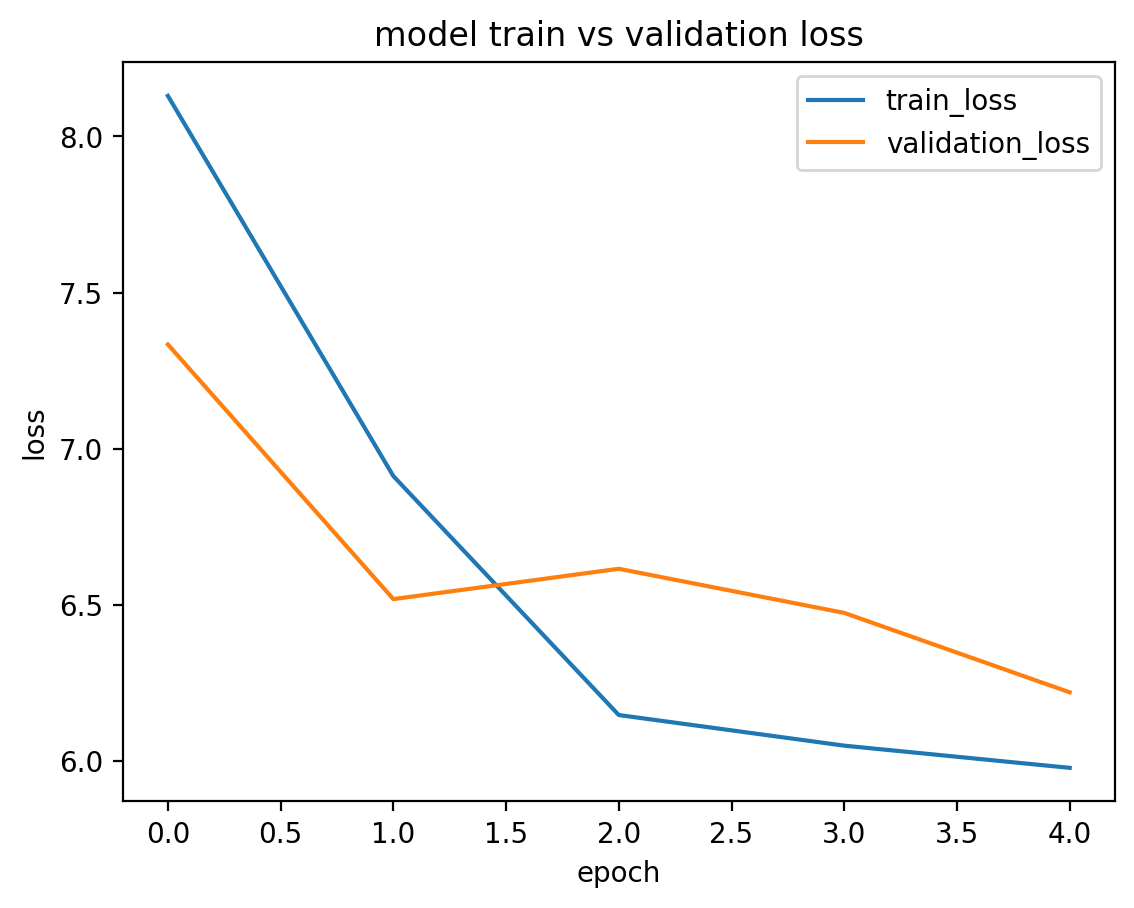

Result stored in ./output/MuGenTransformer_v3_5281685788687_16v2f/


In [25]:
epochs = 5
batchsize = 28
output_path = f"./output/MuGenTransformer_v3_{epochs}{batchsize}{int(time.time())}_16v2f/"


my_training_batch_generator = My_Custom_Generator(all_song_tokenised, batchsize, sequence_length)
my_validation_batch_generator = My_Custom_Generator(all_song_tokenised, batchsize, sequence_length, val_split=0.1)


if not os.path.exists(output_path):
    os.mkdir(output_path)

weight_path = output_path + "music-gen-weight.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    weight_path,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint,gen_callback]

history = model.fit(x = my_training_batch_generator,
                    callbacks = callbacks_list,                    
                   epochs = epochs,
                   verbose = 1,
                   validation_data = my_validation_batch_generator)

train_loss += history.history['loss']
val_loss += history.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper right')
plt.savefig(output_path + 'loss.png')
plt.show()
print("Result stored in {}".format(output_path))

In [26]:
print(sequence_length)

100


In [27]:
seed_len = 100
num_note_to_gen = 1000

song_idx = random.randint(0,len(all_song_tokenised)-1)
seq_start_at = random.randint(0,len(all_song_tokenised[song_idx])-sequence_length)   
start_tokens = all_song_tokenised[song_idx][seq_start_at:seq_start_at + seed_len].tolist()
# start_tokens = inf_song[:seed_len]
while (start_tokens == [()]*sequence_length):
    print("Got all zeros, rerolling")
    song_idx = random.randint(0,len(all_song_tokenised)-1)
    seq_start_at = random.randint(0,len(all_song_tokenised[song_idx])-sequence_length)   
    start_tokens = all_song_tokenised[song_idx][seq_start_at:seq_start_at + sequence_length].tolist()
    
ori = start_tokens.copy()
backup = ori.copy()
# start_tokens = 


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sample_from(logits, k):
    logits, indices = tf.math.top_k(logits, k= k, sorted=True)
    indices = np.asarray(indices).astype("int32")
    preds = np.asarray(logits).astype("float32")
    if(unk_tag_idx in indices):
        unk_tag_position = np.where(indices == unk_tag_idx)[0].item()
        indices = np.delete(indices, unk_tag_position)
        preds = np.delete(preds, unk_tag_position)
    preds = softmax(preds)
    return np.random.choice(indices, p=preds)

def convertToRoll(seq_list):
    seq_list = [int_to_combi[i] for i in seq_list]
    roll = mlb.transform(seq_list)
    print(seq_list)
    return roll


k = 10
tokens_generated = []
num_tokens_generated = 0

while num_tokens_generated <= num_note_to_gen:

    x = start_tokens[-sequence_length:]
    pad_len = maxlen - len(start_tokens)
    sample_index = -1
    if pad_len > 0:
        x = start_tokens + [0] * pad_len
        sample_index = len(start_tokens) - 1
    
    x = np.array([x])
    y, _ = model.predict(x)
    sample_token = sample_from(y[0][sample_index], 10)
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
    print(f"generated {num_tokens_generated} notes")
    
piano_roll = convertToRoll(start_tokens)
print("-------------------------------------------")
ori = convertToRoll(ori)

1/1 [==============================] - 1s 1s/step
generated 1 notes
1/1 [==============================] - 0s 27ms/step
generated 2 notes
1/1 [==============================] - 0s 26ms/step
generated 3 notes
1/1 [==============================] - 0s 26ms/step
generated 4 notes
1/1 [==============================] - 0s 26ms/step
generated 5 notes
1/1 [==============================] - 0s 26ms/step
generated 6 notes
1/1 [==============================] - 0s 26ms/step
generated 7 notes
1/1 [==============================] - 0s 25ms/step
generated 8 notes
1/1 [==============================] - 0s 26ms/step
generated 9 notes
1/1 [==============================] - 0s 26ms/step
generated 10 notes
1/1 [==============================] - 0s 26ms/step
generated 11 notes
1/1 [==============================] - 0s 26ms/step
generated 12 notes
1/1 [==============================] - 0s 27ms/step
generated 13 notes
1/1 [==============================] - 0s 25ms/step
generated 14 notes
1/1 [============

In [28]:
def piano_roll_to_pretty_midi(piano_roll_in, fs, program=0, velocity = 64):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    piano_roll = np.where(piano_roll_in == 1, 64, 0)
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI(initial_tempo=100.0)
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')
    print(piano_roll.shape)
    
    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

Save Output

In [29]:
bpm = 150
fs = 1/((60/bpm)/4)
mid_ori = piano_roll_to_pretty_midi(ori.T, fs=fs)
midi_ori_path = "Generated-Music.mid"
if midi_ori_path is not None:
    mid_ori.write(midi_ori_path)

(128, 102)


## Run MIDI file
- According to MIDI cannot run from colab
- Therefore converting to wav before play

In [30]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!fluidsynth -ni font.sf2 Generated-Music.mid -F output.wav -r 44100

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 34 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

In [31]:
from IPython.display import Audio
Audio('output.wav')